# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [26]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import inspect
import time
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from ddpg_agent import Agent
# from ddpg_model import Actor, Critic
# from ddpg_interact import Interact

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 20 Agents
Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.
We are using a 20 Agents environment

- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`


In [3]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis_20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print (brain_name)

ReacherBrain


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14099999684840442


When finished, you can close the environment.

## Agent Set Up

### Hyperparameters

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters 1e-3
LR_ACTOR = 1e-3         # learning rate of the actor 1e-4
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay 0
TIMESTEPS_WAIT = 1     # how many timesteps to wait forlearning

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, seed=1, timestamp=1):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents, action_size), seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Replay memory
        self.timestamp = timestamp

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        # self.memory.add(state, action, reward, next_state, done)
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        self.timestamp += 1

        # Learn, if enough samples are available in memory
        oktolearn = (self.timestamp % TIMESTEPS_WAIT) == 0
        okbatchsize = len(self.memory) > BATCH_SIZE
        # print(oktolearn, okbatchsize)
        if (okbatchsize & oktolearn):
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True, eps=1.):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample(epsilon=eps)
        # action = (action + 1.0) / 2.0
        # return np.clip(action, 0, 1)
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)  # Grad clipping
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        # print('Noise Process: mean {}, drift {}, stdev {} '.format(mu, theta, sigma))
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self, epsilon=1.):
        """Update internal state and return it as a noise sample."""
        x = self.state
        # dx = self.theta * (self.mu - x) + self.sigma * epsilon * np.array([np.random.randn() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * epsilon * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


###  Actor - Critic Network Model

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # self.fc2_drop = nn.Dropout(p=0.05)          # Dropout
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        # x = self.fc2_drop(x)                        # Dropout   
        x = F.leaky_relu(self.fc3(x))
        return F.tanh(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        # self.fc2_drop = nn.Dropout(p=0.05)                     # Dropout
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        # x = self.fc2_drop(x)                                     # Dropout
        x = F.leaky_relu(self.fc3(x))
        return x

## Interaction Routine 

In [10]:
def Interact(env, agent, brain_name, num_agents, train_mode=True, add_noise=True,
             n_episodes=1000, max_t=400, eps_start=1.0, eps_end=0.1, eps_decay=0.999, n_window=40, tgt_score=30):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    print('\rRunning for {} episodes with target score of {}'.format(n_episodes, tgt_score))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('\rUsing {}'.format(device))
    start = time.time()

    # Initialise
    scores = []                                             # list containing scores from each episode
    scores_window = deque(maxlen=n_window)                  # last 100 scores
    eps = eps_start                                         # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]    # reset the environment
        states = env_info.vector_observations                    # get the current state
        score = np.zeros(num_agents)
        for t in range(max_t):
            # Agent Selects Action #
            actions = agent.act(states, add_noise=add_noise, eps=eps)     # Agent action
            # Agent Performs Action #
            env_info = env.step(actions)[brain_name]                # Environment reacts
            next_states = env_info.vector_observations           # get the next state
            rewards = env_info.rewards                           # get the reward
            dones = env_info.local_done                          # see if episode has finished
            # Agent Observes State #
            agent.step(states, actions, rewards, next_states, dones)    # Agent observes new state
            states = next_states                                     # roll over the state to next time step
            score += rewards                                        # update the score
            if any(dones):
                break
        scores_window.append(np.mean(score))        # save most recent score
        scores.append(np.mean(score))               # save most recent score
        eps = max(eps_end, eps_decay*eps)           # decrease epsilon
        # Periodic Check
        if i_episode % n_window == 0:
            end = time.time()
            print('\nElapsed time {:.1f}'.format((end - start)/60), 'Steps {}'.format(i_episode*max_t), 'Agent Steps {}'.format(agent.timestamp), end="")
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            print('\nEpisode {}\tLast Action:'.format(i_episode), actions[0], end="")
            print('\nEpisode {}\tLast Epsilon: {:.2f}'.format(i_episode, eps), end="")
            torch.save(agent.actor_local.state_dict(), './Data/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), './Data/checkpoint_critic.pth')
        if np.mean(scores_window) >= tgt_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-n_window, np.mean(scores_window)))
            break

    return scores


## Create Agent

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, seed=1, timestamp=1)

Noise Process: mean 0.0, drift 0.15, stdev 0.2 


### Check Hyperparameters 

In [42]:
print('BUFFER_SIZE {}, BATCH_SIZE {}, GAMMA {}, TAU {},\n\t\t LR_ACTOR {}, LR_CRITIC {}, WEIGHT_DECAY {}, TIMESTEPS_WAIT {}'.format(BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY, TIMESTEPS_WAIT))
print('Agent:',inspect.signature(agent.__init__))
print('Noise:',inspect.signature(agent.noise.__init__))

BUFFER_SIZE 100000, BATCH_SIZE 128, GAMMA 0.99, TAU 0.001,
		 LR_ACTOR 0.001, LR_CRITIC 0.001, WEIGHT_DECAY 0, TIMESTEPS_WAIT 1
Agent: (state_size, action_size, num_agents, seed=1, timestamp=1)
Noise: (size, seed, mu=0.0, theta=0.15, sigma=0.2)


## Learn

In [14]:
scores = Interact(env, agent, brain_name, num_agents, train_mode=True, add_noise=True, n_episodes=1000,
                  max_t=1000, eps_start=1, eps_end=0.2, eps_decay=0.999, n_window=10, tgt_score=40)

Running for 1000 episodes with target score of 40
Using cuda:0

Elapsed time 2.4 Steps 10000 Agent Steps 10001
Episode 10	Average Score: 0.78
Episode 10	Last Action: [-1.          0.7341786   0.6690035   0.72353077]
Episode 10	Last Epsilon: 0.99
Elapsed time 4.7 Steps 20000 Agent Steps 20001
Episode 20	Average Score: 2.49
Episode 20	Last Action: [-1.          1.          0.83675295  0.80358607]
Episode 20	Last Epsilon: 0.98
Elapsed time 7.1 Steps 30000 Agent Steps 30001
Episode 30	Average Score: 7.93
Episode 30	Last Action: [ 1.          0.9697141   0.6633419  -0.32955512]
Episode 30	Last Epsilon: 0.97
Elapsed time 9.6 Steps 40000 Agent Steps 40001
Episode 40	Average Score: 13.85
Episode 40	Last Action: [ 0.19294363 -0.65493757  1.         -0.787564  ]
Episode 40	Last Epsilon: 0.96
Elapsed time 12.0 Steps 50000 Agent Steps 50001
Episode 50	Average Score: 22.93
Episode 50	Last Action: [-1.          0.6278692   0.14977092 -0.5603108 ]
Episode 50	Last Epsilon: 0.95
Elapsed time 14.4 Steps

Episode 440	Last Epsilon: 0.64
Elapsed time 108.9 Steps 450000 Agent Steps 450001
Episode 450	Average Score: 36.83
Episode 450	Last Action: [ 0.2083184   0.96528697 -0.6409631   0.21981227]
Episode 450	Last Epsilon: 0.64
Elapsed time 111.4 Steps 460000 Agent Steps 460001
Episode 460	Average Score: 38.37
Episode 460	Last Action: [ 0.6905015  -0.18032442  0.9886065  -1.        ]
Episode 460	Last Epsilon: 0.63
Elapsed time 113.7 Steps 470000 Agent Steps 470001
Episode 470	Average Score: 37.93
Episode 470	Last Action: [ 1.          0.6724396  -0.07035775 -0.8851159 ]
Episode 470	Last Epsilon: 0.62
Elapsed time 115.9 Steps 480000 Agent Steps 480001
Episode 480	Average Score: 37.15
Episode 480	Last Action: [-0.8140661  -1.         -0.71783495 -0.54585093]
Episode 480	Last Epsilon: 0.62
Elapsed time 118.1 Steps 490000 Agent Steps 490001
Episode 490	Average Score: 36.71
Episode 490	Last Action: [ 0.7046014 -0.978834  -0.8926977 -0.8683122]
Episode 490	Last Epsilon: 0.61
Elapsed time 120.3 Step

Episode 880	Last Epsilon: 0.41
Elapsed time 214.1 Steps 890000 Agent Steps 890001
Episode 890	Average Score: 37.43
Episode 890	Last Action: [ 1.         -0.81832665 -0.21065664 -0.02857242]
Episode 890	Last Epsilon: 0.41
Elapsed time 216.6 Steps 900000 Agent Steps 900001
Episode 900	Average Score: 38.13
Episode 900	Last Action: [-0.7723344  -0.57772267 -0.5445637   0.00499638]
Episode 900	Last Epsilon: 0.41
Elapsed time 219.1 Steps 910000 Agent Steps 910001
Episode 910	Average Score: 36.59
Episode 910	Last Action: [ 1.         -1.         -0.9963985  -0.39946988]
Episode 910	Last Epsilon: 0.40
Elapsed time 221.5 Steps 920000 Agent Steps 920001
Episode 920	Average Score: 38.00
Episode 920	Last Action: [-0.13329224  0.9865709  -0.34138262 -0.22455244]
Episode 920	Last Epsilon: 0.40
Elapsed time 223.8 Steps 930000 Agent Steps 930001
Episode 930	Average Score: 37.08
Episode 930	Last Action: [ 0.924192   -0.80117875 -0.23064037  1.        ]
Episode 930	Last Epsilon: 0.39
Elapsed time 226.3 

### Plot Score

In [36]:
pd.Series(scores).to_pickle("./Data/scores.pkl")

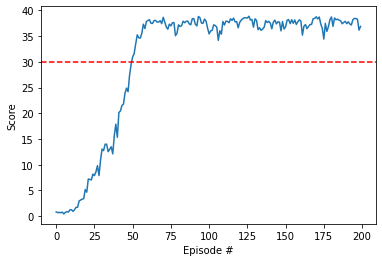

In [41]:
scores_win = scores[0:200]

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_win)), scores_win)
plt.axhline(y=30, color='r', linestyle='dashed')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('./Plots/Average_Score.pdf')
fig.savefig('./Plots/Average_Score.jpg')

## PLAY SMART AGENT

In [ ]:
# Load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('./Data/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('./Data/checkpoint_critic.pth'))

## Play 
for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    for j in range(200):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations    # get the next state
        rewards = env_info.rewards                    # get the reward
        dones = env_info.local_done                   # see if episode has finished
        scores += rewards                             # update the score
        states = next_states                          # roll over the state to next time step
        if np.any(dones):
            break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


In [ ]:
env.close()